 
|Variable|Description|
|:-------|:--------|
|dswrf_sfc_wm2 | Net downward shortwave radiation flux|
|gust_sfc_ms | Wind gust surface (Böe)|
|hpbl_sfc_m | Planetary boundary layer height|
|msl_ms_pa | Mean sea level pressure|
|pottemp_80mto0m_K | Potential temperature difference between 80m and 0m|
|q_2m_1 | Specific humudity in 2 m height|
|q_pfg30_1 | Specific humidity mean over first 30 hPa (~250m)|
|r_pl925_% | Relative humidity in 925 hPa pressure level|
|r_pl950_% | Relative humidity in 950 hPa pressure level |
|shtfl_sfc_wm2 | Net sensible heat flux (conductive heat flux from the Earth's surface to the atmosphere)|
|t_100m_k | Temperature in 100 m height in Kelvin|
|t_2m_k | Temperature in 2 m height in Kelvin|
|t_pfg30_k | Temperature mean ober first 30 hPa (~250m) in Kelvin |
|tcclow_sfc_% | Total Cloud Cover, low level clouds (0km - 2km height)|
|tccmedium_sfc_% | Total Cloud Cover, medium level clouds (2km - 7km height)|
|wdir_100m_dn | wind direction in 100 m height in in degrees|
|wdir_10m_dn | wind direction in 10 m height in in degrees|
|wdir_pfg30_dn | wind direction mean over first 30 hPa (~250m) in degrees|
|wdir_pl925_dn | wind direction in 925 hPa pressure level in degrees|
|wsp_100m_ms | wind speed in 100 m height in meters/second|
|wsp_10m_ms | wind speed in 10 m height in meters/second |
|wsp_pfg30_ms | wind speed mean over first 30 hPa (~250m) in meters/second|
|wsp_pl925_ms | wind speed in 925 hPa pressure leben in meters/second|
|created_on | date and 24 hours divided in quarters|
|azimuth | shows the rotation of the wind turbine|
|elevation | heights of the sun|

In [142]:
reset -fs

# Loading Modules and Datasets

In [143]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import uniform
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score, cross_validate
from sklearn import preprocessing
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, explained_variance_score

import urllib.request
import json
import time
from datetime import datetime
import requests

import plotly as py
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px

from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline

In [144]:
# reading in the first dataframe
with open('griddata_gfs_us_20180101_20190826_03_final.p', 'rb') as f:
    u = pickle._Unpickler(f)
    u.encoding = 'latin1'
    df_fin = u.load()

In [145]:
# rename columns which contains symbols
df_fin = df_fin.rename(columns={'r_pl925_%': 'r_pl925_perc','r_pl950_%': 'r_pl950_perc',
                        'tcclow_sfc_%': 'tcclow_sfc_perc','tccmedium_sfc_%': 'tccmedium_sfc_perc'})
# converting to actual timezone
df_fin.index = df_fin.index.tz_localize(None).to_series(keep_tz=True)

# resampling to a time range of 15 minutes and interpolate between the hourly values
df_fin = df_fin.resample('10min', axis='index').interpolate()
df_fin = df_fin.fillna(method='ffill')

# creating columns with name of the day and month
df_fin['day_name'] = df_fin.index.day_name()
df_fin['day_name'] = df_fin['day_name'].astype('category')
df_fin['month_name'] = df_fin.index.month_name()
df_fin['month_name'] = df_fin['month_name'].astype('category')

In [146]:
# reading in the second dataframe
with open('obs_20180101_20190625_03_final_normed.p', 'rb') as f:
    u = pickle._Unpickler(f)
    u.encoding = 'latin1'
    df_norm = u.load()


In [147]:
# converting to the same timezone as the first dataframe
df_norm.index = df_norm.index.tz_localize(None).to_series(keep_tz=True)

# resample 
# df_norm = df_norm.resample('H').mean()

In [148]:
# combining both dataframes to have one to work in
df = pd.concat([df_norm,df_fin], axis=1)

In [149]:
df.columns

Index(['power_mw_obsnorm', 'power_available_mw_obsnorm', 'target_losses_norm',
       'dswrf_sfc_wm2', 'gust_sfc_ms', 'hpbl_sfc_m', 'msl_ms_pa',
       'pottemp_80mto0m_K', 'q_2m_1', 'q_pfg30_1', 'r_pl925_perc',
       'r_pl950_perc', 'shtfl_sfc_wm2', 't_100m_k', 't_2m_k', 't_pfg30_k',
       'tcclow_sfc_perc', 'tccmedium_sfc_perc', 'wdir_100m_dn', 'wdir_10m_dn',
       'wdir_pfg30_dn', 'wdir_pl925_dn', 'wsp_100m_ms', 'wsp_10m_ms',
       'wsp_pfg30_ms', 'wsp_pl925_ms', 'created_on', 'azimuth', 'elevation',
       'day_name', 'month_name'],
      dtype='object')

In [150]:
# testing if there are any missing values
print(df_norm[df_norm.isnull().any(axis=1)])
print(df_fin[df_fin.isnull().any(axis=1)])

Empty DataFrame
Columns: [power_mw_obsnorm, power_available_mw_obsnorm, target_losses_norm]
Index: []
Empty DataFrame
Columns: [dswrf_sfc_wm2, gust_sfc_ms, hpbl_sfc_m, msl_ms_pa, pottemp_80mto0m_K, q_2m_1, q_pfg30_1, r_pl925_perc, r_pl950_perc, shtfl_sfc_wm2, t_100m_k, t_2m_k, t_pfg30_k, tcclow_sfc_perc, tccmedium_sfc_perc, wdir_100m_dn, wdir_10m_dn, wdir_pfg30_dn, wdir_pl925_dn, wsp_100m_ms, wsp_10m_ms, wsp_pfg30_ms, wsp_pl925_ms, created_on, azimuth, elevation, day_name, month_name]
Index: []

[0 rows x 28 columns]


# Data Cleaning

In [151]:
# drop rows with NaN, since both datasets don't have the same timeframe
df = df.dropna()
df

,power_mw_obsnorm,power_available_mw_obsnorm,target_losses_norm,dswrf_sfc_wm2,gust_sfc_ms,hpbl_sfc_m,msl_ms_pa,pottemp_80mto0m_K,q_2m_1,q_pfg30_1,...,wdir_pl925_dn,wsp_100m_ms,wsp_10m_ms,wsp_pfg30_ms,wsp_pl925_ms,created_on,azimuth,elevation,day_name,month_name
2018-01-01 06:00:00,0.486251,0.911849,0.425598,0.000000,16.777032,1349.927656,99212.062500,0.559356,0.005105,0.004852,...,58.963042,16.548291,9.772748,16.622077,21.963719,2018-01-01 00:00:00+00:00,111.880959,-12.132894,Monday,January
2018-01-01 06:10:00,0.528225,0.932739,0.404513,0.000000,16.748651,1350.376965,99220.020833,0.554256,0.005088,0.004833,...,60.237190,16.589409,9.804977,16.657162,21.955989,2018-01-01 00:00:00+00:00,113.717751,-10.743970,Monday,January
2018-01-01 06:20:00,0.500030,0.905168,0.405137,0.000000,16.720270,1350.826273,99227.979167,0.549156,0.005072,0.004815,...,61.511338,16.630528,9.837206,16.692246,21.948260,2018-01-01 00:00:00+00:00,115.554543,-9.355046,Monday,January
2018-01-01 06:30:00,0.436176,0.918136,0.481961,0.000000,16.691888,1351.275581,99235.937500,0.544055,0.005055,0.004796,...,62.785487,16.671646,9.869435,16.727331,21.940530,2018-01-01 00:00:00+00:00,117.391335,-7.966123,Monday,January
2018-01-01 06:40:00,0.423738,0.920801,0.497063,0.000000,16.663507,1351.724889,99243.895833,0.538955,0.005038,0.004777,...,64.059635,16.712765,9.901665,16.762416,21.932800,2018-01-01 00:00:00+00:00,119.228127,-6.577199,Monday,January
2018-01-01 06:50:00,0.438877,0.916477,0.477600,0.000000,16.635126,1352.174198,99251.854167,0.533855,0.005022,0.004758,...,65.333783,16.753883,9.933894,16.797500,21.925071,2018-01-01 00:00:00+00:00,121.064919,-5.188276,Monday,January
2018-01-01 07:00:00,0.561235,0.933616,0.372381,0.000000,16.606744,1352.623506,99259.812500,0.528755,0.005005,0.004739,...,66.607932,16.795002,9.966123,16.832585,21.917341,2018-01-01 00:00:00+00:00,122.901711,-3.799353,Monday,January
2018-01-01 07:10:00,0.512618,0.958089,0.445471,0.000000,16.630715,1358.166457,99273.179167,0.527215,0.004983,0.004716,...,67.739224,16.860364,10.003695,16.877704,21.956402,2018-01-01 00:00:00+00:00,124.837074,-2.578109,Monday,January
2018-01-01 07:20:00,0.494356,0.966840,0.472484,0.000000,16.654685,1363.709408,99286.545833,0.525675,0.004962,0.004693,...,68.870516,16.925726,10.041266,16.922823,21.995463,2018-01-01 00:00:00+00:00,126.772438,-1.356866,Monday,January
2018-01-01 07:30:00,0.484470,0.970603,0.486133,0.000000,16.678656,1369.252360,99299.912500,0.524135,0.004940,0.004670,...,70.001808,16.991088,10.078838,16.967941,22.034523,2018-01-01 00:00:00+00:00,128.707809,-0.135623,Monday,January


In [152]:
# mean and max difference between windspeed in 100m height and after first 30 hPA
diff_wsp = (abs(df['wsp_pfg30_ms']-df['wsp_100m_ms']))
diff_wsp = pd.DataFrame(diff_wsp)
print(diff_wsp[0].mean())
print(diff_wsp[0].max())

# mean and max difference between wind direction in 100m height and after first 30 hPA
diff_wdir = (df['wdir_pfg30_dn']-df['wdir_100m_dn'])
diff_wdir = pd.DataFrame(diff_wdir)
print(diff_wdir[0].mean())
print(diff_wdir[0].max())

# mean and max difference between temperatures in 100m height and after first 30 hPA
diff_t = (df['t_pfg30_k']-df['t_100m_k'])
diff_t = pd.DataFrame(diff_t)
print(diff_t[0].mean())
print(diff_t[0].max())

# dropping columns for after first 30 hPa since 100m is nearly the same height
if 'wsp_pfg30_ms' in df.columns:
    df.pop('wsp_pfg30_ms')
    df.pop('wdir_pfg30_dn')
    df.pop('t_pfg30_k')
    print(df.columns)

0.15290214960235474
0.7652005515770703
-0.46037204631724776
91.2075218095992
-0.0699522423858068
0.75
Index(['power_mw_obsnorm', 'power_available_mw_obsnorm', 'target_losses_norm',
       'dswrf_sfc_wm2', 'gust_sfc_ms', 'hpbl_sfc_m', 'msl_ms_pa',
       'pottemp_80mto0m_K', 'q_2m_1', 'q_pfg30_1', 'r_pl925_perc',
       'r_pl950_perc', 'shtfl_sfc_wm2', 't_100m_k', 't_2m_k',
       'tcclow_sfc_perc', 'tccmedium_sfc_perc', 'wdir_100m_dn', 'wdir_10m_dn',
       'wdir_pl925_dn', 'wsp_100m_ms', 'wsp_10m_ms', 'wsp_pl925_ms',
       'created_on', 'azimuth', 'elevation', 'day_name', 'month_name'],
      dtype='object')


In [153]:
# encoding the day of the week as well as the month
encoder = preprocessing.OneHotEncoder(dtype=np.int,categories=[['Monday','Tuesday','Wednesday','Thursday',
                                                                'Friday','Saturday','Sunday'],['January',
                                                                'February','March','April','May','June',
                                                                'July','August','September','October',
                                                                'November','December']])
onehotfeat = ['day_name','month_name']
for i in onehotfeat:
    cat_feat = pd.DataFrame(encoder.fit_transform(df[['day_name','month_name']]).toarray(),
                            columns=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday',
                                     'January','February','March','April','May','June','July','August',
                                     'September','October','November','December'])
cat_feat.index = df.index
df = pd.concat([df,cat_feat], axis=1)

In [154]:
# check duplicates
df[df.index.duplicated()]

,power_mw_obsnorm,power_available_mw_obsnorm,target_losses_norm,dswrf_sfc_wm2,gust_sfc_ms,hpbl_sfc_m,msl_ms_pa,pottemp_80mto0m_K,q_2m_1,q_pfg30_1,...,March,April,May,June,July,August,September,October,November,December


# Data Exploration

# Modelling

## Train test split

In [155]:
features =['dswrf_sfc_wm2', 
    'gust_sfc_ms',
     'hpbl_sfc_m', 'msl_ms_pa',
       'pottemp_80mto0m_K', 'q_2m_1', 'q_pfg30_1', 'r_pl925_perc',
       'r_pl950_perc', 'shtfl_sfc_wm2', 't_100m_k', 't_2m_k',
       'tcclow_sfc_perc', 'tccmedium_sfc_perc', 
#           'wdir_100m_dn', 'wdir_10m_dn',
 #      'wdir_pl925_dn', 
    'wsp_100m_ms'
    , 'wsp_10m_ms', 'wsp_pl925_ms',
       #'created_on',
           'azimuth', 'elevation',
          ]    
X = df[features]
Y1 = df['power_mw_obsnorm']
Y2 = df['power_available_mw_obsnorm']
Y3 = df['target_losses_norm']

x_train1, x_test1, y_train1, y_test1 = train_test_split(X, Y1, test_size=0.25, random_state=5)
x_train2, x_test2, y_train2, y_test2 = train_test_split(X, Y2, test_size=0.25, random_state=5)
x_train3, x_test3, y_train3, y_test3 = train_test_split(X, Y3, test_size=0.25, random_state=5)

## Train test split for timeframes

In [156]:
def timeframe_train_test(x, y, time_start, time_end):
    frame = (y.index >= time_start) & (y.index <= time_end)
    x_test_tf = x[frame]
    y_test_tf = y[frame]
    x_train_tf = x[~frame]
    y_train_tf = y[~frame]
    return x_train_tf, x_test_tf, y_train_tf, y_test_tf

In [157]:
timeframe_start = '2019-01-01 00:00'
timeframe_end = '2019-06-25 01:00'
x_train_tf, x_test_tf, y_train_tf, y_test_tf = timeframe_train_test(X, Y3, timeframe_start, timeframe_end)

In [158]:
def tf_rolling_train_test(x, y, time_start, time_end, interval):
    frame = (y.index >= time_start) & (y.index <= time_end)
    x_test_tf = x[frame]
    y_test_tf = y[frame]
    x_train_tf = x[~frame]
    y_train_tf = y[~frame]
    return x_train_tf, x_test_tf, y_train_tf, y_test_tf

## Functions for evaluation and plotting

In [159]:
def regr_eval(y_test, y_pred, return_scores=False, print_scores=True):
    if print_scores==True:
        print('Mean squared error: '+str(round(mean_squared_error(y_test, y_pred),6)))
        print('Root mean squared error: '+str(round(np.sqrt(mean_squared_error(y_test, y_pred)),6)))
        print('Explained variance score: '+str(round(explained_variance_score(y_test, y_pred),6)))
        print('R-squared score: '+str(round(r2_score(y_test, y_pred),6)))
    if return_scores==True:
        return mean_squared_error(y_test, y_pred),np.sqrt(mean_squared_error(y_test, y_pred)),explained_variance_score(y_test, y_pred),r2_score(y_test, y_pred)

In [160]:
# preprocessing data
def preproc(x_train):
    min_max = preprocessing.MinMaxScaler()
    x_preproc = min_max.fit_transform(x_train)
    return pd.DataFrame(x_preproc, columns=x_train.columns, index=x_train.index)

In [161]:
def plot_resid(y_test, y_pred):
    x = y_test.index
    y1 = y_test
    y2 = y_pred
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=x, y=y1, name='True Values', line_color='#32a852', mode='markers'))
    fig.add_trace(go.Scatter(x=x, y=y2, name='Predicted Values', line_color='#23e2f7', mode='markers'))
    
    fig.show()

In [162]:
def plot_resid_hist(y_test, y_pred):

    x = abs(y_test-y_pred)
    fig = go.Figure()
    fig.add_trace(go.Histogram(x=x, name='Distribution of errors'))
      
    fig.show()

In [163]:
def plot_resid_boxp(y_test, y_pred):

    x = abs(y_test-y_pred)
    fig = go.Figure()
    fig.add_trace(go.Box(x=x, name='Distribution of errors'))
      
    fig.show()

In [164]:
def plot_pred_timeframe(y_test, y_pred):
    for i in range(1,7):
        fig, ax = plt.subplots(figsize=(20,10))
        df_test = y_test.to_frame(name='true')
        df_test['pred'] = y_pred
        df_test = df_test[df_test.index.month == i]
        y_te = df_test['true'].resample('H').mean()
        y_pre = df_test['pred'].resample('H').mean()
        y_te.plot(label='True',color='orange')
        y_pre.plot(label='Predicted',color='blue')
        plt.legend()
    plt.figure(figsize=(20,10.0))
    plt.show()

## Linear Regression

In [42]:
# pred_liniction for power_mw_obsnorm
model = LinearRegression(normalize=True)
y_train1_pred_lin = cross_val_predict(model, preproc(x_train1), y_train1, cv=5)
# model = model.fit(x_train1, y_train1)
# y_test1_pred_lin = model.pred_linict(x_test1)
regr_eval(y_train1, y_train1_pred_lin, return_scores=False)

Mean squared error: 0.005383
Root mean squared error: 0.073366
Explained variance score: 0.795346
R-squared score: 0.795346


In [43]:
# pred_liniction for power_mw_obsnorm
model = LinearRegression()
y_train2_pred_lin = cross_val_predict(model, preproc(x_train2), y_train2, cv=5)
regr_eval(y_train2, y_train2_pred_lin, return_scores=False)

Mean squared error: 0.009008
Root mean squared error: 0.094913
Explained variance score: 0.870148
R-squared score: 0.870148


In [44]:
# pred_liniction for power_available_mw_obsnorm
model = LinearRegression()
y_train3_pred_lin = cross_val_predict(model, x_train3, y_train3, cv=5)
regr_eval(y_train3, y_train3_pred_lin, return_scores=False)

Mean squared error: 0.005217
Root mean squared error: 0.072226
Explained variance score: 0.680321
R-squared score: 0.680321


In [45]:
# plot_resid_hist(y_train3, y_train3_pred_lin)
# plot_resid_boxp(y_train3, y_train3_pred_lin)

## Polynominal Linear Regression

In [46]:
x_train1_poly = PolynomialFeatures(degree=2).fit_transform(x_train1)
model = LinearRegression()
y_train1_pred_poly = cross_val_predict(model, x_train1_poly, y_train1, cv=5)
regr_eval(y_train1, y_train1_pred_poly, return_scores=False)

Mean squared error: 0.004229
Root mean squared error: 0.065034
Explained variance score: 0.839189
R-squared score: 0.839189


In [47]:
x_train2_poly = PolynomialFeatures(degree=2).fit_transform(x_train2)
model = LinearRegression()
y_train2_pred_poly = cross_val_predict(model, x_train2_poly, y_train2, cv=5)
regr_eval(y_train2, y_train2_pred_poly, return_scores=False)

Mean squared error: 0.006498
Root mean squared error: 0.080609
Explained variance score: 0.906337
R-squared score: 0.906337


In [48]:
x_train3_poly = PolynomialFeatures(degree=2).fit_transform(x_train3)
model = LinearRegression()
y_train3_pred_poly = cross_val_predict(model, x_train3_poly, y_train3, cv=5)
regr_eval(y_train3, y_train3_pred_poly, return_scores=False)

Mean squared error: 0.003038
Root mean squared error: 0.055119
Explained variance score: 0.81382
R-squared score: 0.81382


In [49]:
x_train_tf_poly = PolynomialFeatures(degree=2).fit_transform(x_train_tf)
x_test_tf_poly = PolynomialFeatures(degree=2).fit_transform(x_test_tf)
model = LinearRegression()
model = model.fit(x_train_tf_poly, y_train_tf)
y_test_tf_pred = model.predict(x_test_tf_poly)
regr_eval(y_test_tf, y_test_tf_pred, return_scores=False)

Mean squared error: 0.006832
Root mean squared error: 0.082658
Explained variance score: 0.750255
R-squared score: 0.738388


In [50]:
#plot_resid_hist(y_train3, y_train3_pred_poly)
#plot_resid_boxp(y_train3, y_train3_pred_poly)

## Support Vector Regressor

Best results and fastest calculating with only wind features

In [51]:
svr_model = SVR(kernel='rbf')
y_train1_pred_svr = cross_val_predict(svr_model, preproc(x_train1), y_train1, cv=5)
regr_eval(y_train1, y_train1_pred_svr, return_scores=False)

Mean squared error: 0.003431
Root mean squared error: 0.058578
Explained variance score: 0.872703
R-squared score: 0.869536


In [52]:
svr_model = SVR(kernel='rbf')
y_train2_pred_svr = cross_val_predict(svr_model, preproc(x_train2), y_train2, cv=5)
regr_eval(y_train2, y_train2_pred_svr, return_scores=False)

Mean squared error: 0.004514
Root mean squared error: 0.067188
Explained variance score: 0.935737
R-squared score: 0.934929


In [53]:
# predicting losses with support vectore regression
svr_model = SVR(kernel='rbf')
y_train3_pred_svr = cross_val_predict(svr_model, preproc(x_train3), y_train3, cv=5)
regr_eval(y_train3, y_train3_pred_svr, return_scores=False)

Mean squared error: 0.002978
Root mean squared error: 0.054575
Explained variance score: 0.819067
R-squared score: 0.81748


In [54]:
# predicting losses for a whole timeframe
svr_model = SVR(kernel='poly')
svr_model = svr_model.fit(preproc(x_train_tf), y_train_tf)
y_test_tf_pred_svr = svr_model.predict(preproc(x_test_tf))
regr_eval(y_test_tf, y_test_tf_pred_svr, return_scores=False)
#plot_pred_timeframe(y_test_tf, y_test_tf_pred_svr)

Mean squared error: 0.01685
Root mean squared error: 0.129809
Explained variance score: 0.524219
R-squared score: 0.354798


In [55]:
# calculating the losses
#regr_eval(y_train3, (y_train2_pred_svr-y_train1_pred_svr), return_scores=False)
#plot_resid_hist(y_train3, (y_train2_pred_svr-y_train1_pred_svr))
#plot_resid_boxp(y_train3, (y_train2_pred_svr-y_train1_pred_svr))

## KNN

In [56]:
knn_model = KNeighborsRegressor(6)
y_train1_pred_knn = cross_val_predict(knn_model, x_train1, y_train1, cv=5)
regr_eval(y_train1, y_train1_pred_knn, return_scores=False)

Mean squared error: 0.002639
Root mean squared error: 0.051375
Explained variance score: 0.899741
R-squared score: 0.899646


In [57]:
knn_model = KNeighborsRegressor(6)
y_train2_pred_knn = cross_val_predict(knn_model, x_train2, y_train2, cv=5)
regr_eval(y_train2, y_train2_pred_knn, return_scores=False)

Mean squared error: 0.005078
Root mean squared error: 0.071262
Explained variance score: 0.926856
R-squared score: 0.926799


In [58]:
knn_model = KNeighborsRegressor(20)
y_train3_pred_knn = cross_val_predict(knn_model, preproc(x_train3), y_train3, cv=5)
regr_eval(y_train3, y_train3_pred_knn, return_scores=False)
#plot_resid_hist(y_train3, y_train3_pred_knn)
#plot_resid_boxp(y_train3, y_train3_pred_knn)

Mean squared error: 0.001224
Root mean squared error: 0.034979
Explained variance score: 0.925049
R-squared score: 0.925021


In [59]:
knn_model = KNeighborsRegressor(20)
knn_model = knn_model.fit(x_train_tf, y_train_tf)
y_test_tf_pred_knn = knn_model.predict(x_test_tf)
regr_eval(y_test_tf, y_test_tf_pred_knn, return_scores=False)
#plot_pred_timeframe(y_test_tf, y_test_tf_pred_knn)

Mean squared error: 0.01175
Root mean squared error: 0.108398
Explained variance score: 0.582877
R-squared score: 0.550089


In [60]:
regr_eval(y_train3, (y_train2_pred_knn-y_train1_pred_knn), return_scores=False)
#plot_resid_hist(y_train3, (y_train2_pred_knn-y_train1_pred_knn))
#plot_resid_boxp(y_train3, (y_train2_pred_knn-y_train1_pred_knn))

Mean squared error: 0.001274
Root mean squared error: 0.035692
Explained variance score: 0.921944
R-squared score: 0.921934


## Random Forrest Regressor

In [61]:
rfr_model = RandomForestRegressor(n_estimators=10, max_features='sqrt',max_depth=8, min_samples_leaf=10)
y_train1_pred_rfr = cross_val_predict(rfr_model, x_train1, y_train1, cv=5)
regr_eval(y_train1, y_train1_pred_rfr, return_scores=False)

Mean squared error: 0.00316
Root mean squared error: 0.05621
Explained variance score: 0.87987
R-squared score: 0.87987


In [62]:
rfr_model = RandomForestRegressor(n_estimators=10, max_features='sqrt',max_depth=8, min_samples_leaf=10)
y_train2_pred_rfr = cross_val_predict(rfr_model, x_train2, y_train2, cv=5)
regr_eval(y_train2, y_train2_pred_rfr, return_scores=False)

Mean squared error: 0.004445
Root mean squared error: 0.06667
Explained variance score: 0.935929
R-squared score: 0.935929


In [63]:
rfr_model = RandomForestRegressor(n_estimators=10, max_features='sqrt',max_depth=8, min_samples_leaf=10)
y_train3_pred_rfr = cross_val_predict(rfr_model, x_train3, y_train3, cv=5)
regr_eval(y_train3, y_train3_pred_rfr, return_scores=False)

Mean squared error: 0.00171
Root mean squared error: 0.041353
Explained variance score: 0.895206
R-squared score: 0.895206


In [64]:
rfr_model = RandomForestRegressor(#n_estimators=10, max_features='sqrt',max_depth=8, min_samples_leaf=10)
)
rfr_model = rfr_model.fit(x_train_tf, y_train_tf)
y_test_tf_pred_rfr = rfr_model.predict(x_test_tf)
regr_eval(y_test_tf, y_test_tf_pred_rfr, return_scores=False)
#plot_pred_timeframe(y_test_tf, y_test_tf_pred_rfr)

Mean squared error: 0.006202
Root mean squared error: 0.07875
Explained variance score: 0.77769
R-squared score: 0.762542


In [344]:
def moddeling_rolling(x, y, time_start, time_end, regressor, days=1, lag=6):
    rsquared = []
    mean_squared = []
    root_mean_squared = []
    explained_variance = []
    results = [rsquared, mean_squared, root_mean_squared, explained_variance]
    
    y_test_list = []
    y_test_pred_list = []
    y_list = [y_test_list, y_test_pred_list]
    
    date_list = pd.date_range(time_end, periods=24/(lag/6)*days, freq='{}H'.format(lag/6))
    
    for i in range(1,(len(date_list)-1)):
        train_frame = (x.index >= time_start) & (x.index < date_list[i])
        test_frame = (x.index >= date_list[i-1]) & (x.index < date_list[i+1])
        x_test = x[test_frame].shift(lag)[lag:]
        y_test = y[test_frame][lag:]
        x_train = x[train_frame].shift(lag)[lag:]
        y_train = y[train_frame][lag:]
        
        model = regressor(10 #n_estimators=10, max_features='sqrt',max_depth=8, min_samples_leaf=10, random_state=1
                         )
        model = model.fit(x_train, y_train)
        y_test_pred = model.predict(x_test)
        mea, roo, expl, rsq = regr_eval(y_test, y_test_pred, return_scores=True, print_scores=False)
        y_test_list.append(y_test)
        y_test_pred = pd.DataFrame(y_test_pred, index=x_test.index)
        y_test_pred_list.append(y_test_pred)
        rsquared.append(rsq)
        mean_squared.append(mea)
        root_mean_squared.append(roo)
        explained_variance.append(expl)
    return results, y_list

In [345]:
timeframe_start = '2019-01-01 00:00'
timeframe_end = '2019-01-10 00:00'
results, y_list = moddeling_rolling(X, Y3, timeframe_start, timeframe_end, KNeighborsRegressor, 4, 144)

In [346]:
for i in range(1,4):
    lists = [ 'Root mean squared value','Mean squared value', 'Root mean squared value', 'Explained variance value']
    res = sum(results[i])/len(results[i])
    print('The {} is: {}'.format(lists[i],res))

The Mean squared value is: 0.02225127328783326
The Root mean squared value is: 0.14913642105456884
The Explained variance value is: 0.1589677280509338


Termin um halb 12

lagging einbauen - über shift function eine Stunde weiter DONE

tagesmittel ermitteln

naive prognose - saisonale naive prognose - einfach den letzten Wert nehmen für alle weiteren Prognosen

3 stunden voraussagen - (vector) autoregressives modell

In [348]:
#plot_resid_hist(y_train3, y_train3_pred_rfr)
#plot_resid_boxp(y_train3, y_train3_pred_rfr)

# Openweather API

In [70]:
openweather_api_key ='f1afaaf6a82c52ed15b283488ae2f377'
openweather_api_url = 'https://api.openweathermap.org/data/2.5/weather?lat={lat}&lon={lon}&units=metric&appid={your api key}'

urllib.request.urlopen(openweather_api_url).read() 
response = urllib.request.urlopen(openweather_api_url).read()
json_obj = str(response, 'utf-8')
forecast_load = json.loads(json_obj)

In [86]:
def forecast(lat,long):
    url='https://api.openweathermap.org/data/2.5/onecall?lat={}&lon={}&exclude=current,minutely,daily&units=metric&appid=f1afaaf6a82c52ed15b283488ae2f377'.format(lat,long)
    urllib.request.urlopen(url).read() 
    response = urllib.request.urlopen(url).read()
    json_obj = str(response, 'utf-8')
    forecast_load = json.loads(json_obj)
    df_forecast = pd.DataFrame(forecast_load['hourly']).copy()
    df_forecast['dt'] = df_forecast.dt.apply(lambda x : datetime.fromtimestamp(x))
    df_forecast = df_forecast.set_index('dt')
    forecast_cols = ['clouds', 'dew_point', 'feels_like', 'humidity', 'pop','visibility', 'weather']
    dict_forec = {'wind_speed':'wsp_10m_ms','temp':'t_2m_k','wind_deg':'wdir_10m_dn','pressure':'msl_ms_pa'}

    if len(df_forecast.columns)>4:
        for i in forecast_cols:
            df_forecast.pop(i)
    df_forecast = df_forecast.rename(columns=dict_forec)
    df_forecast['msl_ms_pa'] = df_forecast['msl_ms_pa'].apply(lambda x : x*100)
    df_forecast['t_2m_k'] = df_forecast['t_2m_k'].apply(lambda x : x+273,15)

    x_train_forecast = df[['msl_ms_pa', 't_2m_k', 
                           'wdir_10m_dn',
                           'wsp_10m_ms','wsp_100m_ms']].copy()
    y_train_forecast = df['target_losses_norm'].copy()
    x_test_forecast = df_forecast[['msl_ms_pa', 't_2m_k', 
                           'wdir_10m_dn',
                           'wsp_10m_ms']].copy()
    x_test_forecast['wsp_100m_ms'] = x_test_forecast['wsp_10m_ms'].apply(lambda x: x/0.64)

    rfr_model = RandomForestRegressor(n_estimators=10, max_features='sqrt',max_depth=8, min_samples_leaf=10)
    y_train_forecast_pred = cross_val_predict(rfr_model, x_train_forecast, y_train_forecast)
    rfr_model = rfr_model.fit(x_train_forecast, y_train_forecast)
    y_test_forecast_pred = rfr_model.predict(x_test_forecast)
    regr_eval(y_train_forecast, y_train_forecast_pred)
    y_test_forecast_pred = pd.DataFrame(y_test_forecast_pred,index=x_test_forecast.index)
    plt.plot(y_test_forecast_pred)
    plt.title('Forecast for latitude {} and longitude {}'.format(lat,long))
    plt.xticks(rotation=45)
    plt.show()
    return y_test_forecast_pred.rename(columns={0:'target_losses_norm'})

Mean squared error: 0.003345
Root mean squared error: 0.057834
Explained variance score: 0.796733
R-squared score: 0.796732


/Users/matthis/opt/anaconda3/envs/nf/lib/python3.6/site-packages/pandas/plotting/_converter.py:129: FutureWarning:

Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()



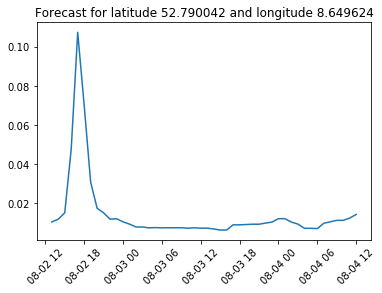

,target_losses_norm
dt,
2020-08-02 13:00:00,0.010502
2020-08-02 14:00:00,0.011917
2020-08-02 15:00:00,0.015166
2020-08-02 16:00:00,0.047736
2020-08-02 17:00:00,0.107303
2020-08-02 18:00:00,0.070092
2020-08-02 19:00:00,0.030864
2020-08-02 20:00:00,0.017493
2020-08-02 21:00:00,0.015166


In [87]:
forecast(52.790042, 8.649624)

- dict with location and coordinates as a tuple

- 6 lat and long coordinates with historical Data to teach the model (calculate wsp100m with ratio of last year)

- getting the current weather forecast via api

- predict einsman actions over the next 48 hours with forecast

- visualize einsman actions in a dashboard with a map(slider for 48 hours), raw data

- hourly and monthly average of ratio between wsp 10 and wsp100


# Climacell API (short term 6hrs)

In [77]:
climacell_api_key = 'QaNtMY27bUQcSLQrQuG5u2k3lZwNAm9a'
climacell_api_url = 'https://api.climacell.co/v3/locations?apikey=QaNtMY27bUQcSLQrQuG5u2k3lZwNAm9a'

In [78]:
url = "https://api.climacell.co/v3/weather/nowcast"
querystring = {"lat":"52.790042","lon":"8.649624","unit_system":"si","timestep":"10","start_time":"now","fields":"wind_gust,wind_speed,temp,surface_shortwave_radiation,baro_pressure","apikey":"QaNtMY27bUQcSLQrQuG5u2k3lZwNAm9a"}
response = requests.request("GET", url, params=querystring)

In [79]:
tex = pd.read_json(response.text)

In [80]:
tex['msl_ms_pa'] = (tex['baro_pressure'].apply(pd.Series))['value'].apply(lambda x: x*100)
tex['t_2m_k'] = (tex['temp'].apply(pd.Series))['value']
tex['gust_sfc_ms'] = (tex['wind_gust'].apply(pd.Series))['value']
tex['wsp_10m_ms'] = (tex['wind_speed'].apply(pd.Series))['value']
tex['wsp_100m_ms'] = (tex['wind_speed'].apply(pd.Series))['value'].apply(lambda x: x/0.64)

In [81]:
df_climacell = tex[['msl_ms_pa','t_2m_k','gust_sfc_ms','wsp_10m_ms','wsp_100m_ms']]

In [82]:
def climacell_pred(lat,long):    
    
    url = "https://api.climacell.co/v3/weather/nowcast"
    querystring = {"lat":"{}".format(lat),"lon":"{}".format(long),"unit_system":"si","timestep":"10","start_time":"now","fields":"wind_gust,wind_speed,temp,surface_shortwave_radiation,baro_pressure","apikey":"QaNtMY27bUQcSLQrQuG5u2k3lZwNAm9a"}
    response = requests.request("GET", url, params=querystring)
    tex = pd.read_json(response.text)
    
    tex['msl_ms_pa'] = (tex['baro_pressure'].apply(pd.Series))['value'].apply(lambda x: x*100)
    tex['t_2m_k'] = (tex['temp'].apply(pd.Series))['value']
    tex['gust_sfc_ms'] = (tex['wind_gust'].apply(pd.Series))['value']
    tex['wsp_10m_ms'] = (tex['wind_speed'].apply(pd.Series))['value']
    tex['wsp_100m_ms'] = (tex['wind_speed'].apply(pd.Series))['value'].apply(lambda x: x/0.64)
    df_climacell = tex[['msl_ms_pa','t_2m_k','gust_sfc_ms','wsp_10m_ms','wsp_100m_ms']]
    
    x_train_forecast = df[['msl_ms_pa', 't_2m_k', 'gust_sfc_ms', 'wsp_10m_ms','wsp_100m_ms']].copy()
    y_train_forecast = df['target_losses_norm'].copy()
    x_test_forecast = df_climacell[['msl_ms_pa', 't_2m_k', 'gust_sfc_ms', 'wsp_10m_ms','wsp_100m_ms']].copy()
    
    rfr_model = RandomForestRegressor(n_estimators=10, max_features='sqrt',max_depth=8, min_samples_leaf=10)
    y_train_forecast_pred = cross_val_predict(rfr_model, x_train_forecast, y_train_forecast)
    rfr_model = rfr_model.fit(x_train_forecast, y_train_forecast)
    y_test_forecast_pred = rfr_model.predict(x_test_forecast)
    regr_eval(y_train_forecast, y_train_forecast_pred)
    y_test_forecast_pred = pd.DataFrame(y_test_forecast_pred,index=x_test_forecast.index)
    
    plt.plot(y_test_forecast_pred)
    plt.title('Forecast for latitude {} and longitude {}'.format(lat,long))
    plt.xticks(rotation=45)
    plt.show()
    return y_test_forecast_pred.rename(columns={0:'target_losses_norm'})

Mean squared error: 0.003492
Root mean squared error: 0.059096
Explained variance score: 0.787792
R-squared score: 0.787766


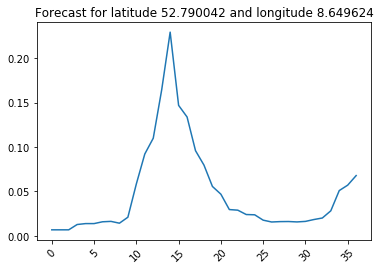

,target_losses_norm
0,0.006752
1,0.006752
2,0.006752
3,0.012732
4,0.013773
5,0.013773
6,0.015805
7,0.016259
8,0.014217
9,0.020952


In [83]:
climacell_pred(52.790042, 8.649624)

## Windspeed 10 m in percent of windspeed 100 m

In [ ]:
wsp_diff = df.wsp_10m_ms / df.wsp_100m_ms
wsp_diff.min()

In [ ]:
sns.boxplot(wsp_diff)

In [ ]:
avg_pow = wsp_diff.resample('W').mean()
avg_pow.plot()
plt.show